In [92]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import MDS
import seaborn as sns         
import numpy as np


def plot_mds(original, gan):
    import seaborn as sns
    sns.set_theme(style="ticks", palette="pastel")
    
    # Matplotlib settings
    fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))
    sns.scatterplot(x=gan[:, 0], y=gan[:, 1], data=gan, color="g")
    sns.scatterplot(x=original[:, 0], y=original[:, 1], data=original, color="b")
    
    # Perfumaria
    ax.set_xlabel("X component")
    ax.set_ylabel("Y component")
    ax.set_title("Multidimensional scaling")
    plt.legend(["Proposed workflow", "Traditional workflow"], 
    bbox_to_anchor=(0, 1.02,1, 0.2), loc="upper left", ncol=2)

    #plt.savefig("data/results/mds.png", dpi=500, bbox_inches='tight')


def mds_plots(snesim_realizations_path, gan_realizations_path):
    traditional = np.load(snesim_realizations_path).reshape((100, -1))
    proposed = np.load(gan_realizations_path).reshape((100, -1))

    mds = MDS(n_components=3, metric=True, random_state=0)
    # Get the embeddings
    original = mds.fit_transform(
        np.load("snesim/data/realizations.npy").reshape((100, -1))
        )

    # Get the embeddings
    gan = mds.fit_transform(
        np.load("generative_model/data/realizations.npy").reshape((100, -1))
        )
    plot_mds(original, gan)
    return original, gan

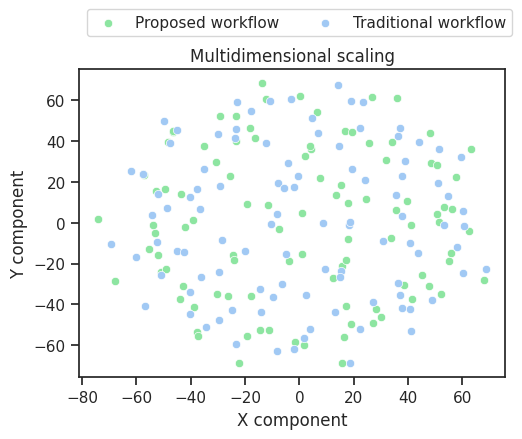

In [93]:
original, gan = mds_plots(snesim_realizations_path="snesim/data/realizations.npy",
            gan_realizations_path="generative_model/data/realizations.npy")

In [94]:
x_t, y_t, z_t = original.T
x_p, y_p, z_p = gan.T

def centroidnp(arr):
    length, dim = arr.shape
    return np.array([np.sum(arr[:, i])/length for i in range(dim)])

centro_t = centroidnp(original)
centro_p = centroidnp(gan)

import math

dist_trad = [math.dist(point, centro_t) for point in original]
dist_prop = [math.dist(point, centro_p) for point in gan]